In [158]:
import librosa
import numpy as np
import pandas as pd
import os
import sys
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
import copy

In [159]:
def get_features(file_path):   

    wav, sr = librosa.load(file_path, sr=44100)
    sample_num = 44100
    data = []

    step_num = int((44100 * 1) /2)
    # hop_length = 44100 // 50
    hop_length = 44100 // 50
    count = 0
    
    
    ind = 0
    while ind + step_num + step_num <= wav.shape[0]:
        frame = wav[ind:ind+step_num+step_num]
        ind = ind + step_num
        count = count + 1
            
        melspec = librosa.feature.melspectrogram(y=frame, sr=44100, hop_length=hop_length)
        melspec = librosa.power_to_db(melspec, ref=np.max)
        
        #logamplitude = librosa.amplitude_to_db(melspec)
        #mfcc = librosa.feature.mfcc(S=logamplitude, n_mfcc=13)
        #zcr = librosa.feature.zero_crossing_rate(y=frame,frame_length=44100, hop_length=hop_length, center=True)
        #rms = librosa.feature.rms(y=frame, S=None, frame_length=44100, hop_length=hop_length, center=True, pad_mode='constant')
        #sc = librosa.feature.spectral_centroid(y=frame, sr=44100, S=None, n_fft=44100, hop_length=hop_length, freq=None, win_length=None, window='hann', center=True, pad_mode='constant')
        #sb = librosa.feature.spectral_bandwidth(y=frame, sr=44100, S=None, n_fft=44100, hop_length=hop_length, win_length=None, window='hann', center=True, pad_mode='constant', freq=None, centroid=None, norm=True, p=2)
        #srp = librosa.feature.spectral_rolloff(y=frame, sr=44100, S=None, n_fft=44100, hop_length=hop_length, win_length=None, window='hann', center=True, pad_mode='constant', freq=None, roll_percent=0.85)
        #chroma = librosa.feature.chroma_stft(y=frame, sr=44100, S=None, norm=np.inf, n_fft=44100, hop_length=hop_length, win_length=None, window='hann', center=True, pad_mode='constant', tuning=None, n_chroma=12)
        #sct = librosa.feature.spectral_contrast(y=frame, sr=44100, S=None, n_fft=44100, hop_length=hop_length, win_length=None, window='hann', center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False)
            
        #print(melspec.shape)
        m1 = np.mean(melspec,axis = 1)
        m2 = np.std(melspec,axis = 1)
            
        #print(mfcc.shape)
        #f1 = np.mean(mfcc,axis = 1)
        #f2 = np.std(mfcc,axis = 1)
            
        #print(zcr.shape)
        #f3 = np.mean(zcr,axis = 1)
        #f4 = np.std(zcr,axis = 1)

        #print(rms.shape)
        #f5 = np.mean(rms,axis = 1)
        #f6 = np.std(rms,axis = 1)
            
        #print(sc.shape)
        #f7 = np.mean(sc,axis = 1)
        #f8 = np.std(sc,axis = 1)
            
        #print(sb.shape)
        #f9 = np.mean(sb,axis = 1)
        #f10 = np.std(sb,axis = 1)
            
        #print(srp.shape)
        #f11 = np.mean(srp,axis = 1)
        #f12 = np.std(srp,axis = 1)
            
        #print(chroma.shape)
        #f13 = np.mean(chroma,axis = 1)
        #f14 = np.std(chroma,axis = 1)
            
        #print(sct.shape)
        #f15 = np.mean(sct,axis = 1)
        #f16 = np.std(sct,axis = 1)
            
        feature_list = [m1,m2]
        features = np.concatenate([feature.flatten() for feature in feature_list])
    
        data.append(features)
        # print(count)
    
    return data

In [160]:
all_data = []
all_labels = []
df = pd.read_csv('ESC-50-master/meta/esc50.csv')
out_col = 'category'
in_col = 'filename'
c2i = {}
i2c = {}
num_classes = 10
df = df[df['esc10']]
categories = sorted(df[out_col].unique())
for i, category in enumerate(categories):
    c2i[category] = i
    i2c[i] = category
        
folder_path = 'ESC-50-master/audio'
for ind in tqdm(range(len(df))):
    row = df.iloc[ind]
    file_path = os.path.join(folder_path, row[in_col])
    new_data = get_features(file_path)
    new_label = [c2i[row['category']]] * len(new_data)
    all_data.extend(new_data)
    all_labels.extend(new_label)
   

100%|██████████| 400/400 [00:14<00:00, 27.05it/s]


In [161]:
import json

for i in range(len(all_data)):
  all_data[i] = all_data[i].tolist()

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.3, random_state=42)


In [162]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
clf.fit(X_train, y_train)
sum(clf.predict(X_test) == y_test) / len(y_test)

0.862037037037037

In [163]:
class linear_random_projection:
    def __init__(self,in_dim,out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.init_projection()

    def init_projection(self):
        self.projection = np.random.normal(0, 1, size=(self.out_dim, self.in_dim))
        self.projection = np.sign(self.projection)

    def encode(self,x):
        enc = self.projection @ x
        enc = enc.squeeze()
        return np.sign(enc)

In [164]:
class hd_model:
    def __init__(self,X_train, X_test, y_train, y_test ,in_dim,out_dim,lr):
        
        scaler = StandardScaler() 
        scaler.fit(X_train)
        self.X_train = X_train
        self.X_test = X_test
        self.X_train = scaler.transform(X_train)
        self.X_test = scaler.transform(X_test)
        
        self.y_train = y_train
        self.y_test = y_test
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.lr = lr

        self.encoder = linear_random_projection(self.in_dim,self.out_dim)
        self.class_hvs = np.zeros((12,self.out_dim))
        
        self.train_encs = []
    
    def train_(self):
        n_train = len(self.X_train)
        for i in range(n_train):
            sample = self.X_train[i]
            label = self.y_train[i]
            enc = self.encoder.encode(sample)  
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            # self.class_hvs[label] += 2 * (1-similarities[label]) * enc
            # self.class_hvs[pred] -= 2 * (1-similarities[pred]) * enc
            self.class_hvs[label] += enc
            self.class_hvs[pred] -= enc
            self.train_encs.append(enc)

    
    def test_(self):
        preds = []
                           
        n_test = len(self.X_test)
        for i in range(n_test):
            sample = self.X_test[i]
            label = self.y_test[i]
            enc = self.encoder.encode(sample)
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            preds.append(pred)
        
        print("================================")
        print(accuracy_score(self.y_test, preds))
        print(f1_score(self.y_test, preds, average="weighted"))
        cm = confusion_matrix(self.y_test, preds,labels=[0,1,2,3,4,5,6,7,8,9,10,11])
        print(cm)
        sns.heatmap(cm, annot=True)
        print("================================")




    def retrain(self):
        for e in range(4):
            count = 0
            print(e)
            for i in range(len(self.train_encs)):
                enc = self.train_encs[i]
                label = self.y_train[i]
                similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
                pred = np.argmax(similarities)
                if pred != label:
                    # self.class_hvs[label] += self.lr * (1-similarities[label]) * enc
                    # self.class_hvs[pred] -= self.lr * (1-similarities[pred]) * enc
                    self.class_hvs[label] += enc
                    self.class_hvs[pred] -= enc
                    count += 1
            print(count)

0.6777777777777778
0.6763802991468149
[[81  0  5  0  0  3  1  0  9  0  0  0]
 [ 1 89  9  1  0  2  0  1  0  3  0  0]
 [11  2 80  0  0  1  6  0  0 13  0  0]
 [ 2  8  3 79  1  0  0  2  0  4  0  0]
 [ 0 20  1 10 50  4  0  5  1 17  0  0]
 [ 5  2  0  0  0 93  6  2 10  1  0  0]
 [37  0  0  0  1  0 65  0  8  6  0  0]
 [ 2 22  6  6  0  1  0 44  1 28  0  0]
 [ 7  0  1  1  0  0  1  0 94  2  0  0]
 [ 0 30 11  3  0  0  0  1  1 57  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]


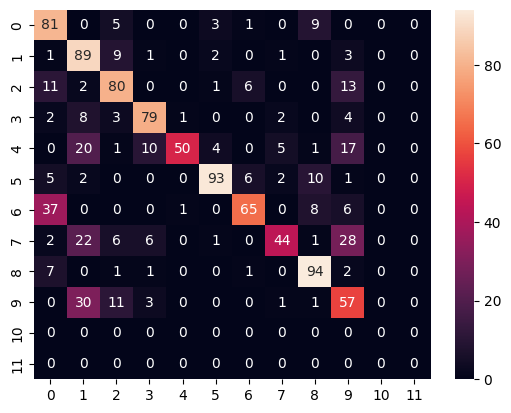

In [176]:
model = hd_model(X_train, X_test, y_train, y_test,256,2000,0.75)
with open('projection.json', 'w') as json_file:
    json.dump(model.encoder.projection.tolist(), json_file, indent=4)
with open('Xtrain.json', 'w') as json_file:
    json.dump(model.X_train.tolist(), json_file, indent=4)
with open('Xtest.json', 'w') as json_file:
    json.dump(model.X_test.tolist(), json_file, indent=4)
with open('Ytrain.json', 'w') as json_file:
    json.dump(y_train, json_file, indent=4)
with open('Ytest.json', 'w') as json_file:
    json.dump(y_test, json_file, indent=4)
model.train_()
model.test_()


0
563
1
416
2
315
3
285
0.8092592592592592
0.8104570258527062
[[ 92   0   3   0   0   0   0   1   2   1   0   0]
 [  2 102   1   0   0   1   0   0   0   0   0   0]
 [  2   3 103   0   0   0   1   0   0   4   0   0]
 [  2   7   0  79   4   1   0   3   0   3   0   0]
 [  0   8   0   0  78   2   0   1   0  19   0   0]
 [  7   1   4   0  13  92   0   1   0   1   0   0]
 [ 13   0   0   0   0   1  96   0   3   4   0   0]
 [  3   7   0   3   6   1   0  58   2  30   0   0]
 [  5   0   0   1   1   0   1   0  96   2   0   0]
 [  0  13   1   1   2   0   0   7   1  78   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


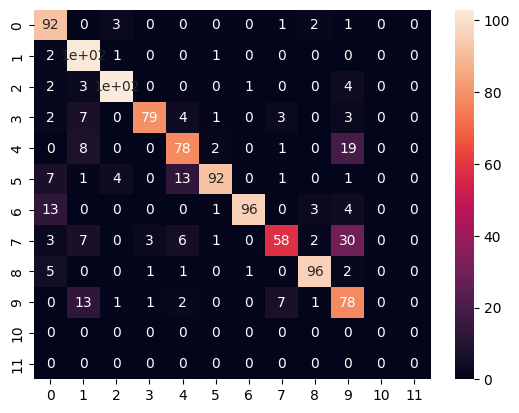

In [177]:
model.retrain()
model.test_()
with open('class_hvs.json', 'w') as json_file:
    json.dump(model.class_hvs.tolist(), json_file, indent=4)